# IMPORTS AND INSTALLS

In [ ]:
!pip install openai
!pip install PyMuPDF
!pip install gradio

# osm
!pip install osmnx
!pip install geopy
!pip install scikit-learn

# gee topo
!pip install
!pip install earthengine-api
!pip install folium
!pip install geemap
!pip install geopandas
!pip install rasterio
!pip install numpy pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.2 MB/s eta 0:00:00
ERROR: You must give at least one requirement to install (see "pip help install")
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import openai
import datetime
import gradio
from openai import OpenAI
import json
from google.colab import files
import io
import fitz
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances

#OSM
import geopandas
import matplotlib.pyplot as plt
import osmnx
import seaborn as sns
from shapely.geometry import Point, LineString

#GEE
from PIL import Image
import os
import ee
import folium
import geemap


API KEY

In [ ]:
# Replace 'your-api-key' with your actual API key
client = OpenAI(api_key="")

# CHATGPT JSON CALL

In [ ]:
def callGPT_JSONMode(messages, model="gpt-4o"):
    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=conversationLog,
    )
    return response.choices[0].message.model_dump()["content"]

In [ ]:
prompt_template = """
You are a helpfull assistant. Try your best to fullfill the user query. To empower
you further you can use the "generateGeoData" tool. in oder to use it answer in the following
JSON format:

{"message":"your regular message to  the user",
"tool":"generateGeoData"
"args":{"operation_type":"layout", "city_name":"Barcelona"}
}

if you dont need to use the tool or you have already used it and retreived its anwser, leave "tool" and "args" empty. If you use the tool
use the message field to explain your argument choices.
The argument operation_type can either be "layout" (to get the map of the streets of a city) or
topography to the the topographical features of the city.

Ensure to always answer in exactly that json fomrat. Do not add any comments or thoughts.
Below is the user query:
"""

In [ ]:
# setup a user prompt where GPT would need the current time in order to be able to answer
user_prompt = "what is the time right now?"

In [ ]:
# simply attach the userprompt at the end of the prompt_template
conversationLog = [{"role": "system", "content": prompt_template},
                {"role": "user", "content": user_prompt}]

# GEE AUTHENTICATOR

In [ ]:
# Authenticate and initialize
ee.Authenticate()  # Run this only once; follow the on-screen instructions
# Explicitly set the project ID
ee.Initialize(project='ee-') # Replace 'your-project-id' with your actual Google Cloud project ID

## INTERACTIVE Map

interactive map

In [ ]:
def generateGeoData(operation_type,city_name):

  if operation_type == "layout":
    graph = osmnx.graph_from_place(city_name, network_type='drive')
    _, edges = osmnx.graph_to_gdfs(graph)

    # plotting the projection
    fig, ax = osmnx.plot_graph(graph, node_size= 0, bgcolor= '#FFFFFF', edge_color='#000000', edge_linewidth= 0.2)
    image_path = f"/content/drive/MyDrive/amoebas_studio/img/Layout/{city_name}_street_network.png"
    fig.savefig(image_path, dpi=400, bbox_inches='tight')
    return fig, ax

  elif operation_type == "topography":
    # Import NASADEM dataset and select the elevation band
    dataset = ee.Image('NASA/NASADEM_HGT/001')
    elevation = dataset.select('elevation')

    # Get the boundary of Barcelona from OpenStreetMap or Earth Engine datasets
    barcelona = ee.FeatureCollection("FAO/GAUL/2015/level2") \
        .filter(ee.Filter.eq('ADM2_NAME', f'{city_name}'))  # Filtering for Barcelona

    # Clip the elevation map to the Barcelona boundary
    elevation_barcelona = elevation.clip(barcelona)

    # Define Black & White visualization parameters
    elevationVis = {
        'min': 0,
        'max': 2000,
        'palette': ['black', 'white']  # Black for low areas, white for high elevations
    }

    # Create an interactive Folium map centered at Barcelona
    map_center = [41.3851, 2.1734]  # Latitude, Longitude of Barcelona
    m = geemap.Map(center=map_center, zoom=12)

    # Add the clipped Barcelona elevation layer to the map
    m.addLayer(elevation_barcelona, elevationVis, f"{city_name} Elevation")

    # Display the interactive map
    return m
  else:
    return "no geo data"

In [ ]:
generateGeoData("topography", "Barcelona")

Map(center=[41.3851, 2.1734], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

# MAP GENERATOR **PNG**-TIF

In [ ]:
import os
import ee
import geemap
import rasterio
import osmnx as ox
import matplotlib.pyplot as plt
from PIL import Image
from geopy.geocoders import Nominatim
from google.colab import files  # For downloading files in Colab

# ✅ Ensure the /content/img directory exists
os.makedirs("/content/img", exist_ok=True)

# ✅ Function to get city boundaries from OpenStreetMap (OSM)
def get_osm_boundary(city_name):
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.geocode(city_name, exactly_one=True)

    if location:
        bbox = location.raw['boundingbox']
        lat_min, lat_max, lon_min, lon_max = map(float, bbox)
        return ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])  # Use OSM boundary
    else:
        print(f"❌ Error: Unable to find city '{city_name}' in OSM.")
        return None

# ✅ Define file paths
def define_file_paths(city_name):
    base_path = "/content/img"
    return {
        "elevation_tiff": os.path.join(base_path, f"{city_name}_elevation.tif"),
        "elevation_png": os.path.join(base_path, f"{city_name}_elevation.png"),
        "street_network": os.path.join(base_path, f"{city_name}_street_network.png")
    }

# ✅ Function to generate geographic data (Street Layout or Topography)
def generateGeoData(operation_type, city_name):

    if operation_type == "layout":
        try:
            graph = ox.graph_from_place(city_name, network_type='drive')
            fig, ax = ox.plot_graph(graph, node_size=0, bgcolor='#FFFFFF', edge_color='#000000', edge_linewidth=0.2)

            image_path = define_file_paths(city_name)["street_network"]
            fig.savefig(image_path, dpi=400, bbox_inches='tight')
            print(f"✅ Street layout saved: {image_path}")
            return image_path

        except Exception as e:
            print(f"❌ Error generating street layout: {e}")
            return None

    elif operation_type == "topography":
        print(f"🔍 Searching for {city_name} in OpenStreetMap...")

        # Step 1: Fetch city boundary from OSM
        bbox = get_osm_boundary(city_name)
        if bbox is None:
            print(f"❌ Error: Could not find {city_name} boundary in OSM.")
            return None

        print(f"✅ City boundary found! Clipping elevation map to {city_name}...")

        # Step 2: Load the NASADEM elevation dataset
        dataset = ee.Image('NASA/NASADEM_HGT/001')
        elevation = dataset.select('elevation')

        # Step 3: Clip the elevation data to the city's bounding box
        elevation_city = elevation.clip(bbox)

        # Step 4: Define output file paths
        paths = define_file_paths(city_name)
        tif_file, png_file = paths["elevation_tiff"], paths["elevation_png"]

        # Step 5: Export the elevation map as GeoTIFF
        export_scale = 100  # Adjust resolution if needed
        geemap.ee_export_image(
            elevation_city, filename=tif_file, scale=export_scale, region=bbox, file_per_band=False
        )
        print(f"✅ GeoTIFF saved: {tif_file}")

        # Step 6: Convert GeoTIFF to PNG
        if os.path.exists(tif_file):
            with rasterio.open(tif_file) as src:
                array = src.read(1)  # Read first band
                array[array == src.nodata] = 0  # Replace NoData values with 0

                # Normalize elevation values (0-255 grayscale)
                min_val, max_val = src.read(1).min(), src.read(1).max()
                normalized_array = ((array - min_val) / (max_val - min_val)) * 255
                normalized_array = normalized_array.astype("uint8")

                # Convert to grayscale image
                img = Image.fromarray(normalized_array)
                img = img.convert("L")

                # Save the PNG
                img.save(png_file)

                # Step 7: Show the processed elevation map
                plt.figure(figsize=(8, 8))
                plt.imshow(img, cmap="gray")
                plt.axis("off")
                plt.title(f"{city_name} Elevation Map")
                plt.show()

            print(f"✅ PNG saved: {png_file}")

            # ✅ Download PNG file
            files.download(png_file)

            return png_file

        else:
            print("❌ Error: GeoTIFF file not found.")
            return None

    else:
        return "❌ Error: Invalid operation type."




🔍 Searching for Barcelona in OpenStreetMap...
✅ City boundary found! Clipping elevation map to Barcelona...
Generating URL ...
Please wait ...
Data downloaded to /content/img/Barcelona_elevation.tif
✅ GeoTIFF saved: /content/img/Barcelona_elevation.tif


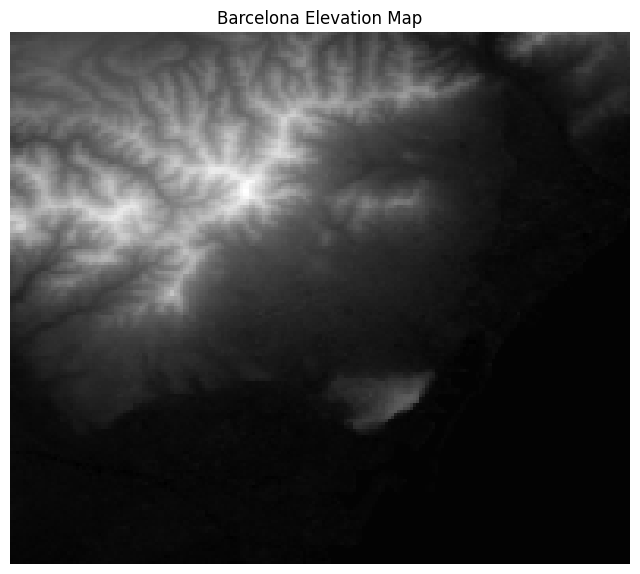

✅ PNG saved: /content/img/Barcelona_elevation.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

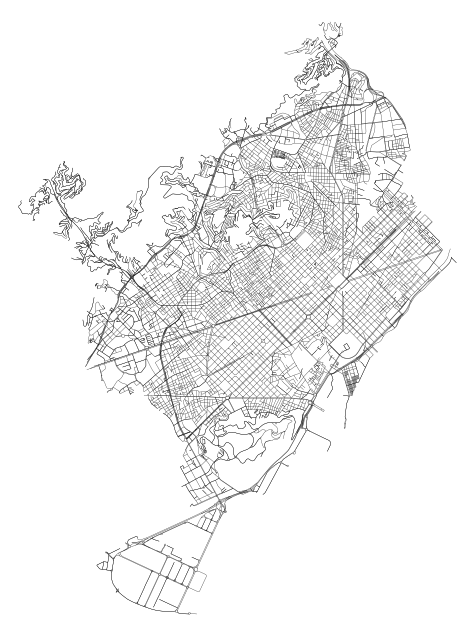

✅ Street layout saved: /content/img/Barcelona_street_network.png


'/content/img/Barcelona_street_network.png'

In [ ]:
generateGeoData("topography", "Barcelona")
generateGeoData("layout", "Barcelona")


# IMG2SVG

In [ ]:
!git clone --recurse-submodules https://github.com/loicland/img2svg

Cloning into 'img2svg'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 66 (delta 12), reused 8 (delta 8), pack-reused 43 (from 1)
Receiving objects: 100% (66/66), 262.62 KiB | 5.25 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Submodule 'grid-graph' (https://gitlab.com/1a7r0ch3/grid-graph) registered for path 'grid-graph'
Submodule 'multilabel-potrace' (https://gitlab.com/1a7r0ch3/multilabel-potrace) registered for path 'multilabel-potrace'
Submodule 'parallel-cut-pursuit' (https://gitlab.com/1a7r0ch3/parallel-cut-pursuit) registered for path 'parallel-cut-pursuit'
Cloning into '/content/img2svg/grid-graph'...
remote: Enumerating objects: 143, done.        
remote: Counting objects: 100% (60/60), done.        
remote: Compressing objects: 100% (35/35), done.        
remote: Total 143 (delta 21), reused 60 (delta 21), pack-reused 83 (from 1)        
Receiving objects: 100% (143/14

In [ ]:
!python /content/img2svg/setup.py install

/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/py

In [ ]:
!python /content/img2svg/img2svg.py -h


usage: img2svg.py [-h] [-f FILE] [-p OUT_PATH] [-o OUT_SIZE] [-lc LINE_COLOR] [-lw LINE_WIDTH]
                  [-a APPLY] [-r REG] [-s SMOOTH] [-lt LINE_TOLERANCE] [-ct CURVE_TOLERANCE]

IMG TO VECTOR

options:
  -h, --help            show this help message and exit
  -f FILE, --file FILE  Input file name
  -p OUT_PATH, --out_path OUT_PATH
                        Path of svg outputfile default = empty : inputfile.svg
  -o OUT_SIZE, --out_size OUT_SIZE
                        Size of svg outputfile
  -lc LINE_COLOR, --line_color LINE_COLOR
                        Color of contour, default = none. supported (r,g,b,k,w), or a char triplet
  -lw LINE_WIDTH, --line_width LINE_WIDTH
                        Width of contour in pixels. Default: 1
  -a APPLY, --apply APPLY
                        Function to apply before partition: sqrt, log,none (default)
  -r REG, --reg REG     Regularization strength: the higher the fewer components. Default = 1.0.
  -s SMOOTH, --smooth SMOOTH
            

In [ ]:
from PIL import Image

# Load the image
image_path = "/content/img/Barcelona_street_network.png"
output_resized = "/content/img/Barcelona_street_network_resized.png"

img = Image.open(image_path)
img = img.resize((1000, 1000))  # Resize to a smaller size (adjust as needed)
img.save(output_resized)

print("✅ Resized image saved:", output_resized)


✅ Resized image saved: /content/img/Barcelona_street_network_resized.png


In [ ]:
!python /content/img2svg/img2svg.py -f /content/img/Barcelona_street_network_resized.png -p /content/output.svg --line_color k

Reading image of size 1000 by 1000 with 3 channels
Cut-pursuit initialization:
	1 connected component(s), 0 saturated, and at most 1 reduced edge(s).

Cut-pursuit iteration 1 (max. 10): 
	Split... 227923 new activated edge(s).
	Compute connected components... 3895 connected component(s), 0 saturated.
	Compute reduced graph... 4023 reduced edge(s).
	Solve reduced problem: 
	Merge... 4240 deactivated edge(s).
	relative iterate evolution 9.29e+00 (tol. 1.00e-02)
	3343 connected component(s), 0 saturated, and at most 3342 reduced edge(s).

Cut-pursuit iteration 2 (max. 10): 
	Split... 86274 new activated edge(s).
	Compute connected components... 9039 connected component(s), 2802 saturated.
	Compute reduced graph... 17551 reduced edge(s).
	Solve reduced problem: 
	Merge... 13297 deactivated edge(s).
	relative iterate evolution 1.35e+01 (tol. 1.00e-02)
	4569 connected component(s), 1894 saturated, and at most 12772 reduced edge(s).

Cut-pursuit iteration 3 (max. 10): 
	Split... 92822 new act

# **GRADIO**

this works perfect but doesnt give svg

In [ ]:
import gradio as gr
import openai


# ✅ Prompt Template for ChatGPT API
prompt_template = """
You are a helpful assistant. Try your best to fulfill the user query. To empower
you further, you can use the "generateGeoData" tool. In order to use it, answer in the following
JSON format:

{
  "message": "your regular message to the user",
  "tool": "generateGeoData",
  "args": {"operation_type": "layout", "city_name": "Barcelona"}
}

If you don't need to use the tool or you have already used it and retrieved its answer, leave "tool" and "args" empty. If you use the tool,
use the message field to explain your argument choices.
The argument "operation_type" can either be "layout" (to get the map of the streets of a city) or
"topography" (to get the topographical features of the city).

Ensure to always answer in exactly that JSON format. Do not add any comments or thoughts.
Below is the user query:
"""

# ✅ Function to call OpenAI API and get JSON response
def callGPT_JSONMode(user_prompt, model="gpt-4o"):
    conversationLog = [
        {"role": "system", "content": prompt_template},
        {"role": "user", "content": user_prompt}
    ]

    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=conversationLog,
    )

    return response.choices[0].message.model_dump()["content"]

# ✅ Gradio interface function (with GPT-4o integration)
def generate_city_map_with_GPT(user_prompt):
    # Call GPT-4o to analyze the prompt
    gpt_response = callGPT_JSONMode(user_prompt)

    # Parse GPT response
    try:
        response_json = eval(gpt_response)  # Convert JSON string to Python dictionary
        message = response_json.get("message", "❌ GPT did not return a valid message.")
        tool = response_json.get("tool", "")
        args = response_json.get("args", {})

        if tool == "generateGeoData" and args:
            operation_type = args.get("operation_type", "unknown")
            city_name = args.get("city_name", "unknown")

            if operation_type not in ["layout", "topography"]:
                return f"❌ Error: Invalid operation type detected: {operation_type}", None, None

            # Call generateGeoData using the detected parameters
            output_file = generateGeoData(operation_type, city_name)

            if output_file is None:
                return f"❌ Unable to generate {operation_type} map for {city_name}.", None, None

            return message, output_file, output_file
        else:
            return message, None, None

    except Exception as e:
        return f"❌ Error parsing GPT response: {e}", None, None


# ✅ Updated Gradio interface with ChatGPT integration
interface = gr.Interface(
    fn=generate_city_map_with_GPT,
    inputs=gr.Textbox(label="Enter a prompt (e.g., 'Generate a street map of Barcelona', 'Show me Berlin topography')"),
    outputs=[
        gr.Textbox(label="Status"),
        gr.Image(label="Preview", type="filepath"),
        gr.File(label="Download Map")
    ],
    title="AI-Powered City Map Generator",
    description="Enter a city name and the type of map you want. AI will analyze your prompt and generate a city map accordingly."
)

# ✅ Launch Gradio app
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d2e6e6099714b143a4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


this is with svg

In [ ]:
import gradio as gr
import openai
from PIL import Image

# ✅ OpenAI API Configuration
client = openai.OpenAI(api_key="your-api-key")  # Replace with your actual API key

# ✅ Prompt Template for ChatGPT API
prompt_template = """
You are a helpful assistant. Try your best to fulfill the user query. To empower
you further, you can use the "generateGeoData" tool. In order to use it, answer in the following
JSON format:

{
  "message": "your regular message to the user",
  "tool": "generateGeoData",
  "args": {"operation_type": "layout", "city_name": "Barcelona"}
}

If you don't need to use the tool or you have already used it and retrieved its answer, leave "tool" and "args" empty. If you use the tool,
use the message field to explain your argument choices.
The argument "operation_type" can either be "layout" (to get the map of the streets of a city) or
"topography" (to get the topographical features of the city).

Ensure to always answer in exactly that JSON format. Do not add any comments or thoughts.
Below is the user query:
"""

# ✅ Function to call OpenAI API and get JSON response
def callGPT_JSONMode(user_prompt, model="gpt-4o"):
    conversationLog = [
        {"role": "system", "content": prompt_template},
        {"role": "user", "content": user_prompt}
    ]

    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=conversationLog,
    )

    return response.choices[0].message.model_dump()["content"]

# ✅ Function to resize image before SVG conversion
def resize_image_for_svg(input_path, output_path, max_size=(1000, 1000)):
    img = Image.open(input_path)
    original_width, original_height = img.size

    # Calculate the scaling factor to fit within max_size while maintaining proportions
    scale_factor = min(max_size[0] / original_width, max_size[1] / original_height)

    # Compute new dimensions while maintaining aspect ratio
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    img = img.resize((new_width, new_height), Image.LANCZOS)  # High-quality resizing
    img.save(output_path)

    return output_path


# ✅ Gradio interface function (with GPT-4o integration, SVG support & resizing)
def generate_city_map_with_GPT(user_prompt):
    # Call GPT-4o to analyze the prompt
    gpt_response = callGPT_JSONMode(user_prompt)

    # Parse GPT response
    try:
        response_json = eval(gpt_response)  # Convert JSON string to Python dictionary
        message = response_json.get("message", "❌ GPT did not return a valid message.")
        tool = response_json.get("tool", "")
        args = response_json.get("args", {})

        if tool == "generateGeoData" and args:
            operation_type = args.get("operation_type", "unknown")
            city_name = args.get("city_name", "unknown")

            if operation_type not in ["layout", "topography"]:
                return f"❌ Error: Invalid operation type detected: {operation_type}", None, None, None

            # Call generateGeoData using the detected parameters
            output_file = generateGeoData(operation_type, city_name)

            if output_file is None:
                return f"❌ Unable to generate {operation_type} map for {city_name}.", None, None, None

            # Determine if vectorization is needed
            generate_vector = "vector" in user_prompt.lower()

            # ✅ If vectorization is requested, resize the image first
            svg_file = None
            if generate_vector and operation_type == "layout":
                vector_input = output_file  # Use the generated image
                resized_image = f"/content/img/{city_name}_resized.png"

                # Resize the image before vectorization
                resized_image = resize_image_for_svg(vector_input, resized_image)

                svg_file = f"/content/img/{city_name}_vector.svg"

                # Run img2svg separately (assumes setup exists in Colab)
                !python /content/img2svg/img2svg.py -f {resized_image} -p {svg_file} --line_color k

            # ✅ Return results
            if generate_vector:
                return f"✅ {operation_type.capitalize()} map for {city_name} generated!", output_file, output_file, svg_file
            else:
                return f"✅ {operation_type.capitalize()} map for {city_name} generated!", output_file, output_file, None

    except Exception as e:
        return f"❌ Error parsing GPT response: {e}", None, None, None

# ✅ Updated Gradio interface with SVG Download Option
interface = gr.Interface(
    fn=generate_city_map_with_GPT,
    inputs=gr.Textbox(label="Enter a prompt (e.g., 'Barcelona street layout', 'Berlin topography vector')"),
    outputs=[
        gr.Textbox(label="Status"),
        gr.Image(label="Preview", type="filepath"),
        gr.File(label="Download Map"),
        gr.File(label="Download Vector Map (SVG)")
    ],
    title="City Map Generator",
    description="Enter a city name and the type of map you want. AI will analyze your prompt and generate a city map accordingly. If you request a vector map, an SVG file will also be provided."
)

# ✅ Launch Gradio app
interface.launch()




Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4397006f60d8d1182e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
